In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
import sys
import os
module_path = Path("../src/")
os.chdir(module_path)
sys.path.append(module_path)
from data_access.load_file import load_table
from data_processing.functions import *
from data_preparation import compute_work_item_times
from data_processing import features
import warnings
warnings.filterwarnings("ignore")

Load data and compute duration

In [3]:
filename = Path("../data/gdsc2_public.csv")
data = load_table(filename)
times = compute_work_item_times(data)

Split into open and closed work items. We want to analyze the closed ones

In [4]:
is_open = pd.isnull(times["duration_in_days"])
times_open = times[is_open]
times_closed = times[~is_open]

Get weekdays from starting end end date

In [5]:
times_closed.loc[:, "start_weekday"] = times_closed["start"].apply(lambda x: x.weekday() + 1)
times_closed.loc[:, "end_weekday"] = times_closed["end"].apply(lambda x: x.weekday() + 1)

In [6]:
times_closed.describe()

,duration,duration_in_days,start_weekday,end_weekday
count,10522,10522.000000,10522.000000,10522.000000
mean,56 days 17:30:21.035449,56.729416,3.001521,2.765539
std,103 days 14:34:48.010747,103.607514,1.419780,1.407361
min,0 days 00:00:04,0.000000,1.000000,1.000000
25%,4 days 21:19:35,4.890000,2.000000,2.000000
50%,19 days 00:24:53.500000,19.020000,3.000000,3.000000
75%,62 days 04:58:09,62.210000,4.000000,4.000000
max,1112 days 22:08:49,1112.920000,7.000000,7.000000


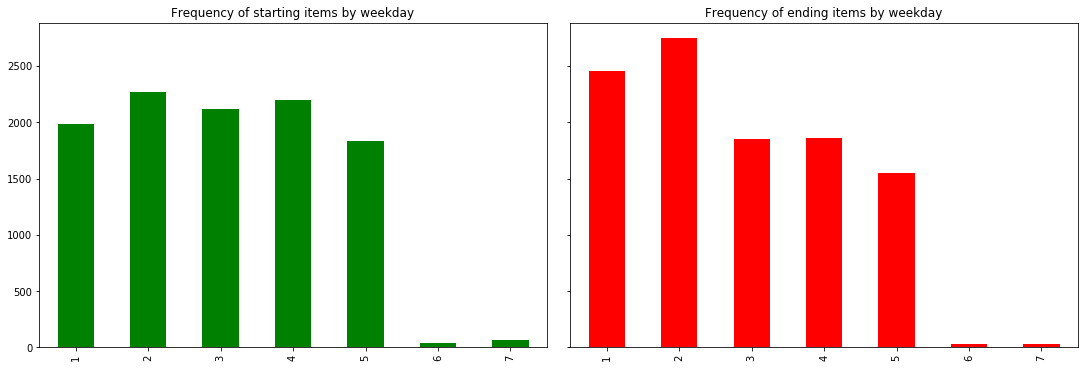

In [7]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(15,5), sharey=True, sharex=True)
times_closed.start_weekday.value_counts().sort_index().plot(ax=axs[0], kind="bar",
                                                            title="Frequency of starting items by weekday", color='g')
times_closed.end_weekday.value_counts().sort_index().plot(ax=axs[1], kind="bar",
                                                          title="Frequency of ending items by weekday", color='r')

Mondays and Tuesdays are most common to open and close items. After Tuesday the frequency is decreasing. We should check if the weekdays also have an impact on the duration.

In [8]:
weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

In [9]:
def get_weekday(week_nr):
    mapping = dict(zip(range(1,8), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]))
    return mapping[week_nr]

In [10]:
times_closed.loc[:, "start_weekday_cat"] = times_closed["start_weekday"].apply(lambda x: get_weekday(x))
times_closed.loc[:, "end_weekday_cat"] = times_closed["end_weekday"].apply(lambda x: get_weekday(x))
times_closed["start_weekday_cat"] = pd.Categorical(times_closed["start_weekday_cat"], categories=weekdays)
times_closed["end_weekday_cat"] = pd.Categorical(times_closed["end_weekday_cat"], categories=weekdays)

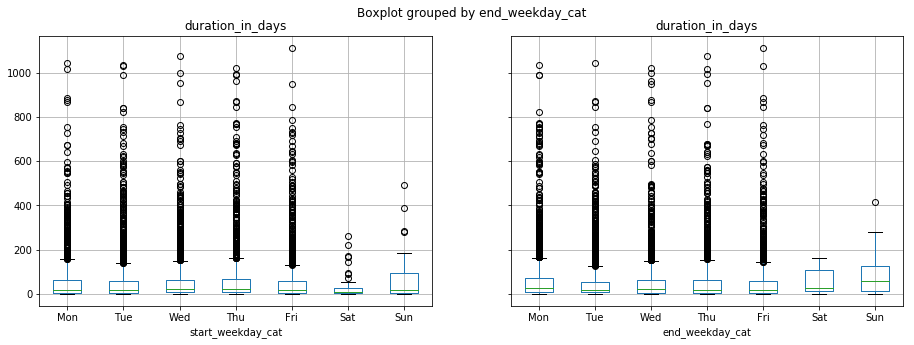

In [11]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(15,5), sharey=True, sharex=True)
times_closed.boxplot(column="duration_in_days", by="start_weekday_cat", ax=axs[0])
times_closed.boxplot(column="duration_in_days", by="end_weekday_cat", ax=axs[1])

Looks like the starting and ending weekday doesn't make a big difference. We should go back in granularity and check the duration corresponding to:

1. Weeks
2. Months
3. Years

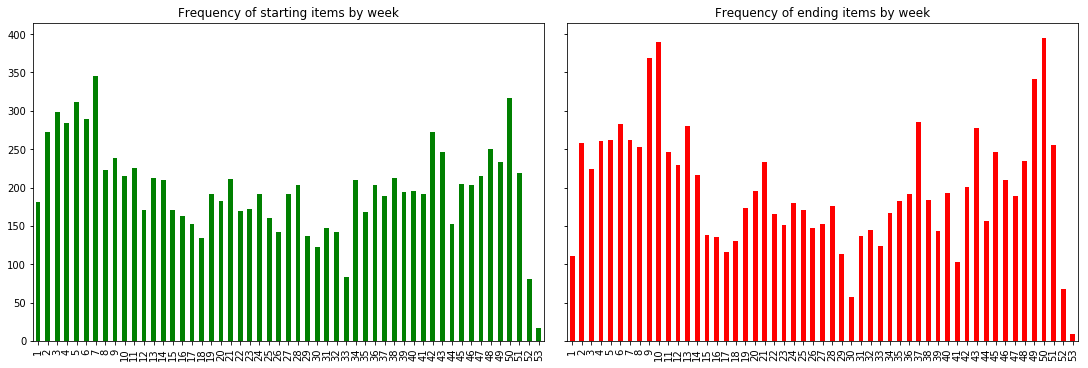

In [12]:
times_closed.loc[:, "start_week"] = times_closed["start"].apply(lambda x: x.week)
times_closed.loc[:, "end_week"] = times_closed["end"].apply(lambda x: x.week)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(15,5), sharey=True, sharex=True)
times_closed.start_week.value_counts().sort_index().plot(ax=axs[0], kind="bar",
                                                         title="Frequency of starting items by week", color='g')
times_closed.end_week.value_counts().sort_index().plot(ax=axs[1], kind="bar",
                                                       title="Frequency of ending items by week", color='r')

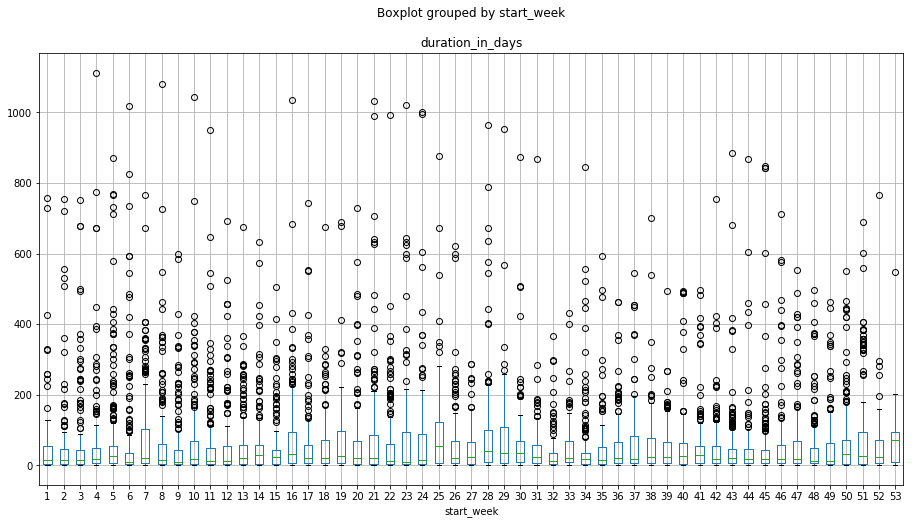

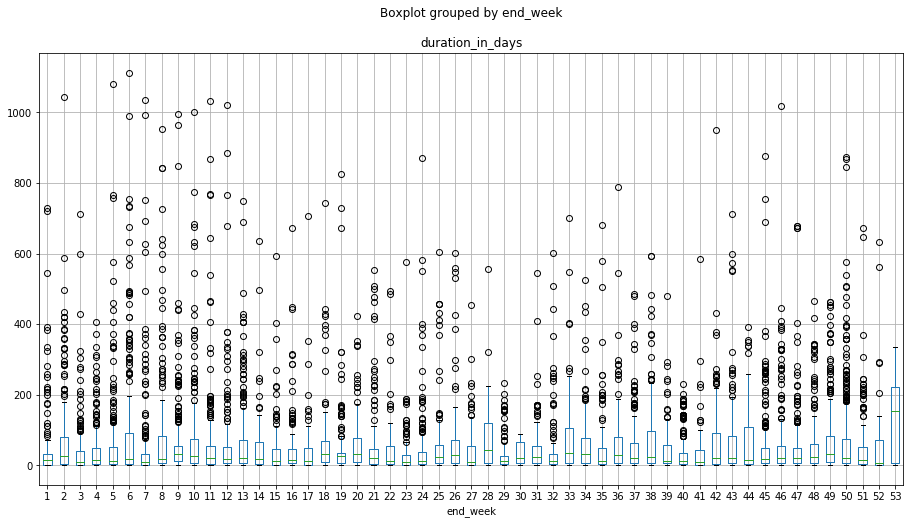

In [13]:
times_closed.boxplot(column="duration_in_days", by="start_week", figsize=(15,8))
times_closed.boxplot(column="duration_in_days", by="end_week", figsize=(15,8))

Seems like there is some kind of cycle during the year, which could coher to release phases. After a release the new arising tickets are more complex. After some time complexity decreases until the next release.

Let's look at 2. Months

In [14]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
def get_monthname(month_nr, months=months):
    mapping = dict(zip(range(1,len(months)+1), months))
    return mapping[month_nr]

In [15]:
times_closed.loc[:, "start_month"] = times_closed["start"].apply(lambda x: x.month)
times_closed.loc[:, "end_month"] = times_closed["end"].apply(lambda x: x.month)
times_closed.loc[:, "start_month_cat"] = times_closed["start_month"].apply(lambda x: get_monthname(x))
times_closed.loc[:, "end_month_cat"] = times_closed["end_month"].apply(lambda x: get_monthname(x))
times_closed["start_month_cat"] = pd.Categorical(times_closed["start_month_cat"], categories=months)
times_closed["end_month_cat"] = pd.Categorical(times_closed["end_month_cat"], categories=months)

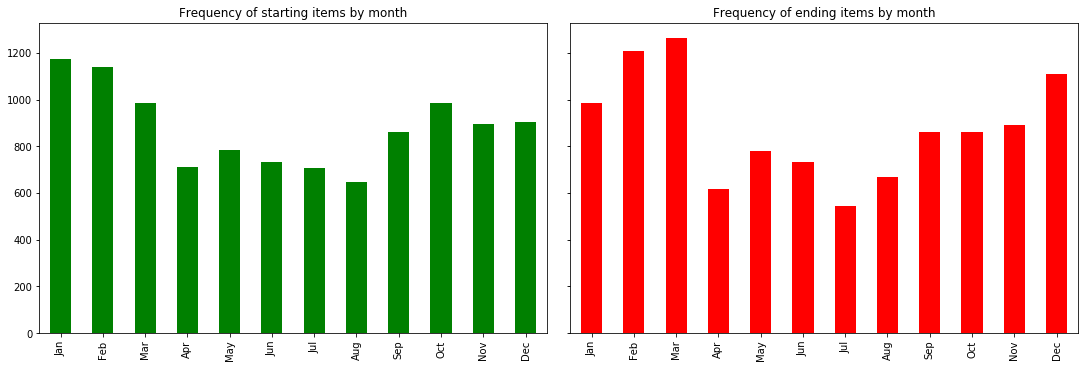

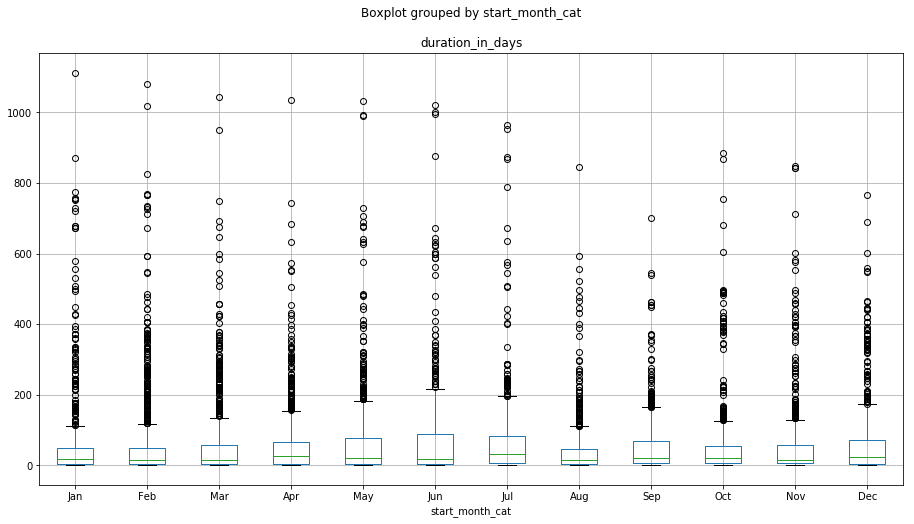

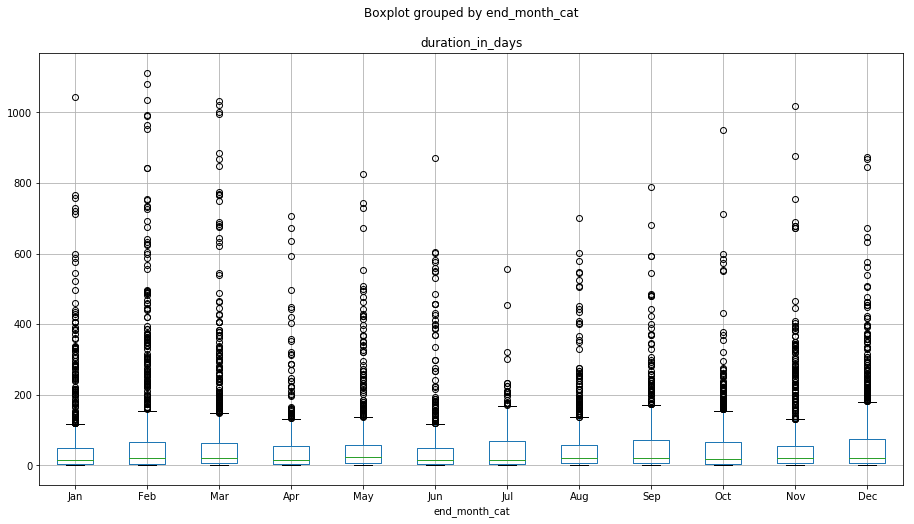

In [16]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(15,5), sharey=True, sharex=True)
times_closed.start_month_cat.value_counts().sort_index().plot(ax=axs[0], kind="bar",
                                                         title="Frequency of starting items by month", color='g')
times_closed.end_month_cat.value_counts().sort_index().plot(ax=axs[1], kind="bar",
                                                       title="Frequency of ending items by month", color='r')

times_closed.boxplot(column="duration_in_days", by="start_month_cat", figsize=(15,8))
times_closed.boxplot(column="duration_in_days", by="end_month_cat", figsize=(15,8))

There is a more general cycle across the months as well. Now we want to check if we can find a sort of cycle during the years too.

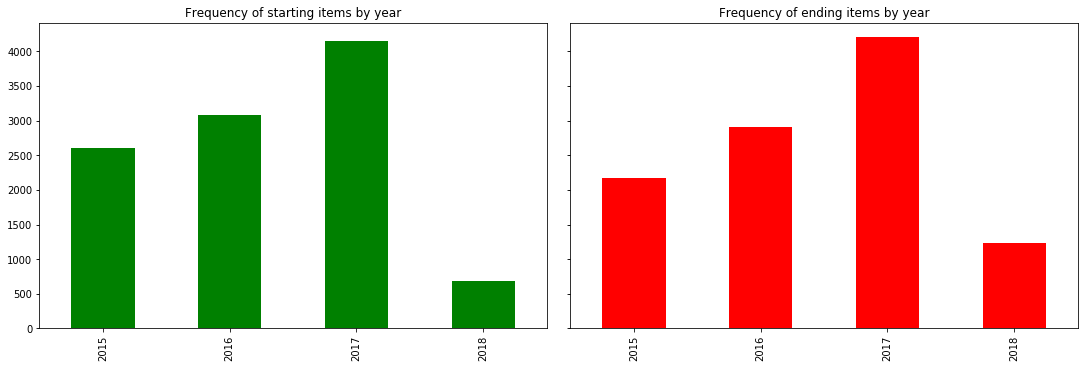

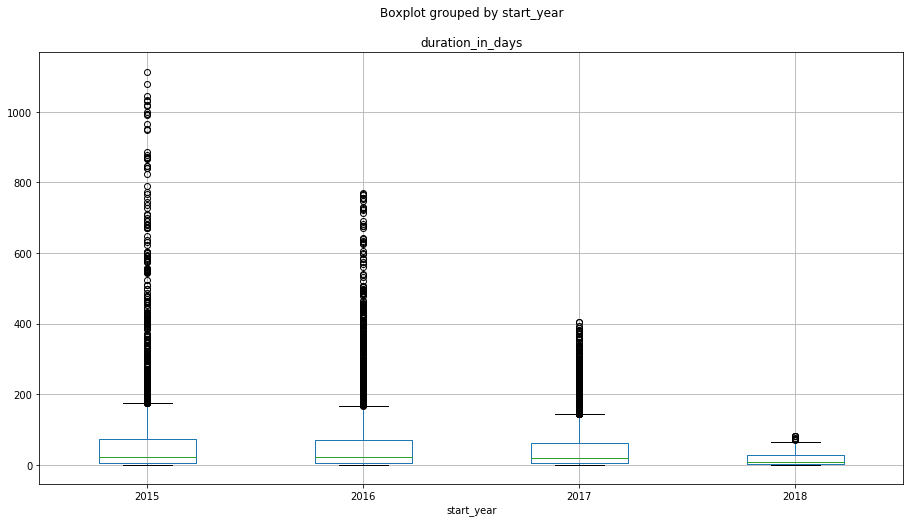

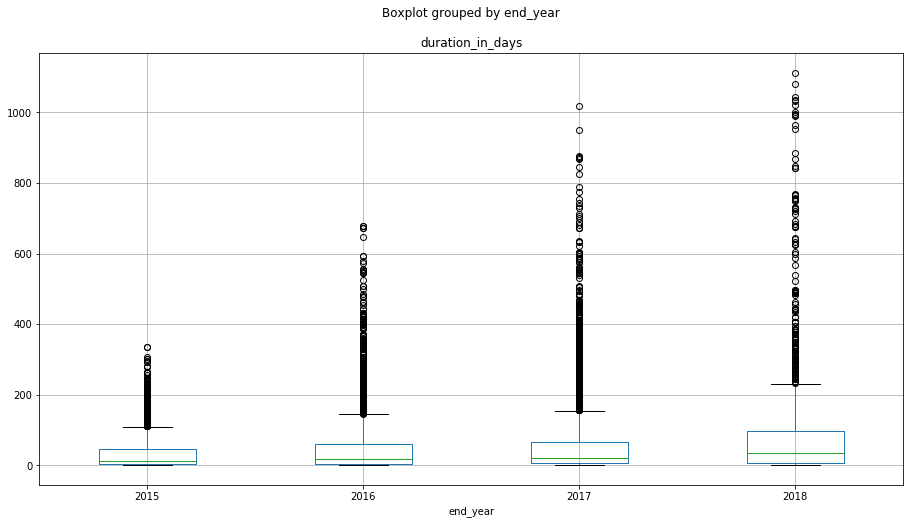

In [17]:
times_closed.loc[:, "start_year"] = times_closed["start"].apply(lambda x: x.year)
times_closed.loc[:, "end_year"] = times_closed["end"].apply(lambda x: x.year)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(15,5), sharey=True, sharex=True)
times_closed.start_year.value_counts().sort_index().plot(ax=axs[0], kind="bar",
                                                         title="Frequency of starting items by year", color='g')
times_closed.end_year.value_counts().sort_index().plot(ax=axs[1], kind="bar",
                                                       title="Frequency of ending items by year", color='r')
times_closed.boxplot(column="duration_in_days", by="start_year", figsize=(15,8))
times_closed.boxplot(column="duration_in_days", by="end_year", figsize=(15,8))

This is interesting: The frequency of new items increases while the duration decreases. Which could have different reasons. Maybe they add new systems which lead to more problems and in same step they hire new support employeers to work on those problems.
The duration of the closed items by year decreases which could also fit in the assumption. With new support employeers and systems, really old problems can be solved.

Now I want to go deeper in the connection between the time data and the duration per phase. We later want to find a good mean value for open work items maybe based on the timestamp they were opened. We go from bottom up with

1. Weekday
2. Week
3. Month
4. Year

In [18]:
phase_times = time_for_phase(data)
work_times = features.work_times(phase_times, time_col="duration_in_days")
time_info = features.timestamp_information(times, timestamp_col="start")

In [19]:
open_wis = times[pd.isnull(times["duration_in_days"])]["work_item"].values
times_open = work_times[work_times["work_item"].isin(open_wis)]
times_closed = work_times[~work_times["work_item"].isin(open_wis)]

In [20]:
final = pd.merge(times_closed, time_info)

In [21]:
final["start_weekday_cat"] = final["start_weekday"].apply(lambda x: get_weekday(x))
final["start_weekday_cat"] = pd.Categorical(final["start_weekday_cat"], categories=weekdays)

In [22]:
time_cols = ['Analyze', 'Design', 'Build', 'Test', 'Package', 'Accept', 'Deploy', 'Clarify']
weekday_df = pd.DataFrame(columns=time_cols, index=weekdays)
for col in time_cols:
    weekday_df.loc[:, col] = final.groupby("start_weekday_cat")[col].mean()

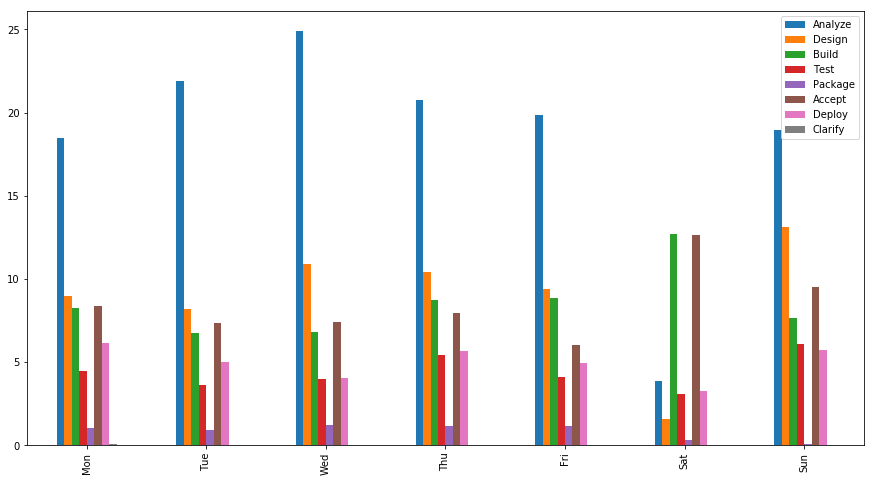

In [23]:
weekday_df.plot.bar(figsize=(15,8))

In [24]:
time_cols = ['Analyze', 'Design', 'Build', 'Test', 'Package', 'Accept', 'Deploy', 'Clarify']
week_df = pd.DataFrame(columns=time_cols, index=final["start_week"].unique())
for col in time_cols:
    week_df.loc[:, col] = final.groupby("start_week")[col].mean()

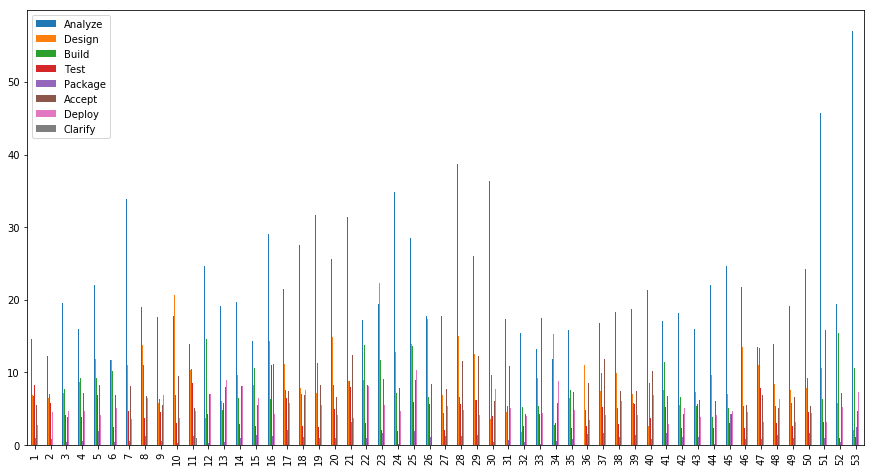

In [25]:
week_df.plot.bar(figsize=(15,8))

In [26]:
time_cols = ['Analyze', 'Design', 'Build', 'Test', 'Package', 'Accept', 'Deploy', 'Clarify']
month_df = pd.DataFrame(columns=time_cols, index=final["start_month"].unique())
for col in time_cols:
    month_df.loc[:, col] = final.groupby("start_month")[col].mean()

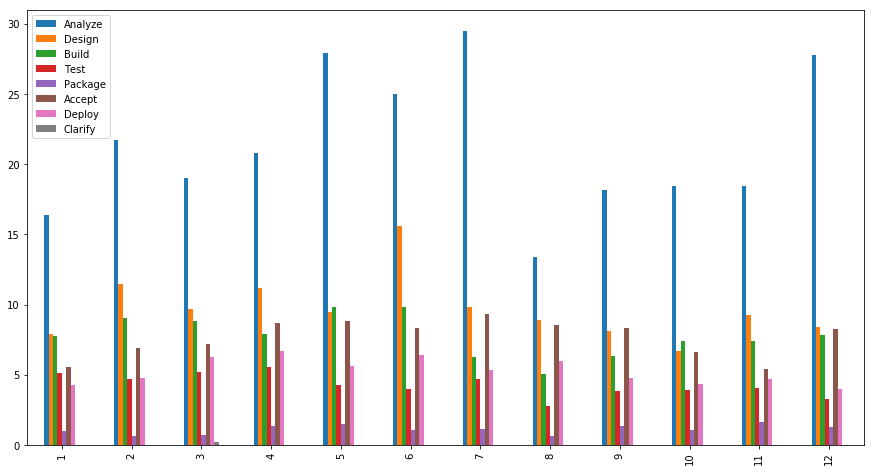

In [27]:
month_df.plot.bar(figsize=(15,8))

In [28]:
time_cols = ['Analyze', 'Design', 'Build', 'Test', 'Package', 'Accept', 'Deploy', 'Clarify']
year_df = pd.DataFrame(columns=time_cols, index=final["start_year"].unique())
for col in time_cols:
    year_df.loc[:, col] = final.groupby("start_year")[col].mean()

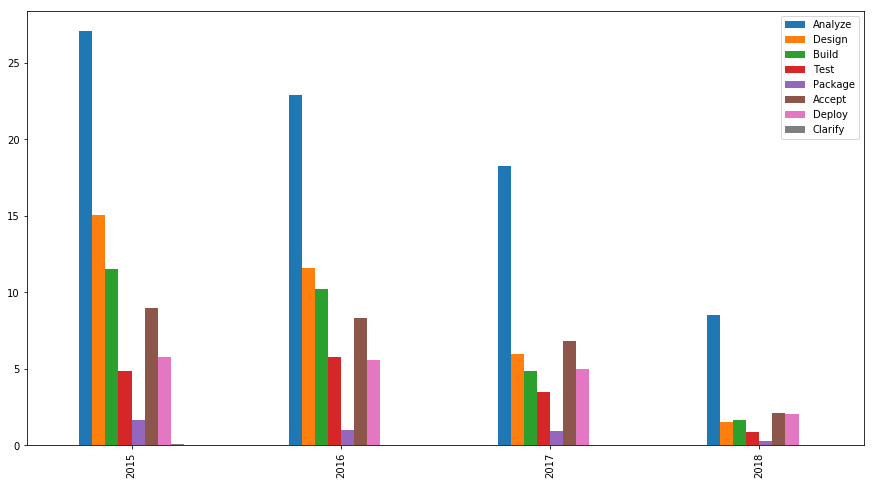

In [29]:
year_df.plot.bar(figsize=(15,8))

So the mean duration is kind of periodic during the weeks for the different phases and is decreasing regarding to the years. So a combination of both could be a good mean value

To let our later model learn that the timestamp information is cyclistic we need to transform the information. We will use sin and cos transformation for that